# References/Web Search Cookbook

## Introduction

This cookbook is designed to guide you in effectively utilizing the latest Mistral Large 2 model to perform web searches and seamlessly integrate credible sources into your responses. One of the persistent challenges in chatbots and Retrieval-Augmented Generation (RAG) systems is their propensity to fabricate sources or misformat URLs, undermining the reliability of their outputs. Mistral's cutting-edge capabilities overcome these limitations, ensuring precise and trustworthy information retrieval.

## Mistral's Web Search Capabilities

The Mistral Large 2 model (mistral-large-latest) features robust web search integration, enabling it to accurately retrieve and reference sources within its responses. This functionality ensures that source content is not only correctly retrieved but also presented in a clear and properly formatted manner, enhancing the transparency and dependability of the provided information.

By harnessing Mistral's advanced natural language processing (NLP) and seamless web search integration, developers can create more reliable and trustworthy applications. This makes Mistral an ideal solution for use cases where accuracy and credibility are critical, such as research tools, customer support systems, and knowledge-based platforms.

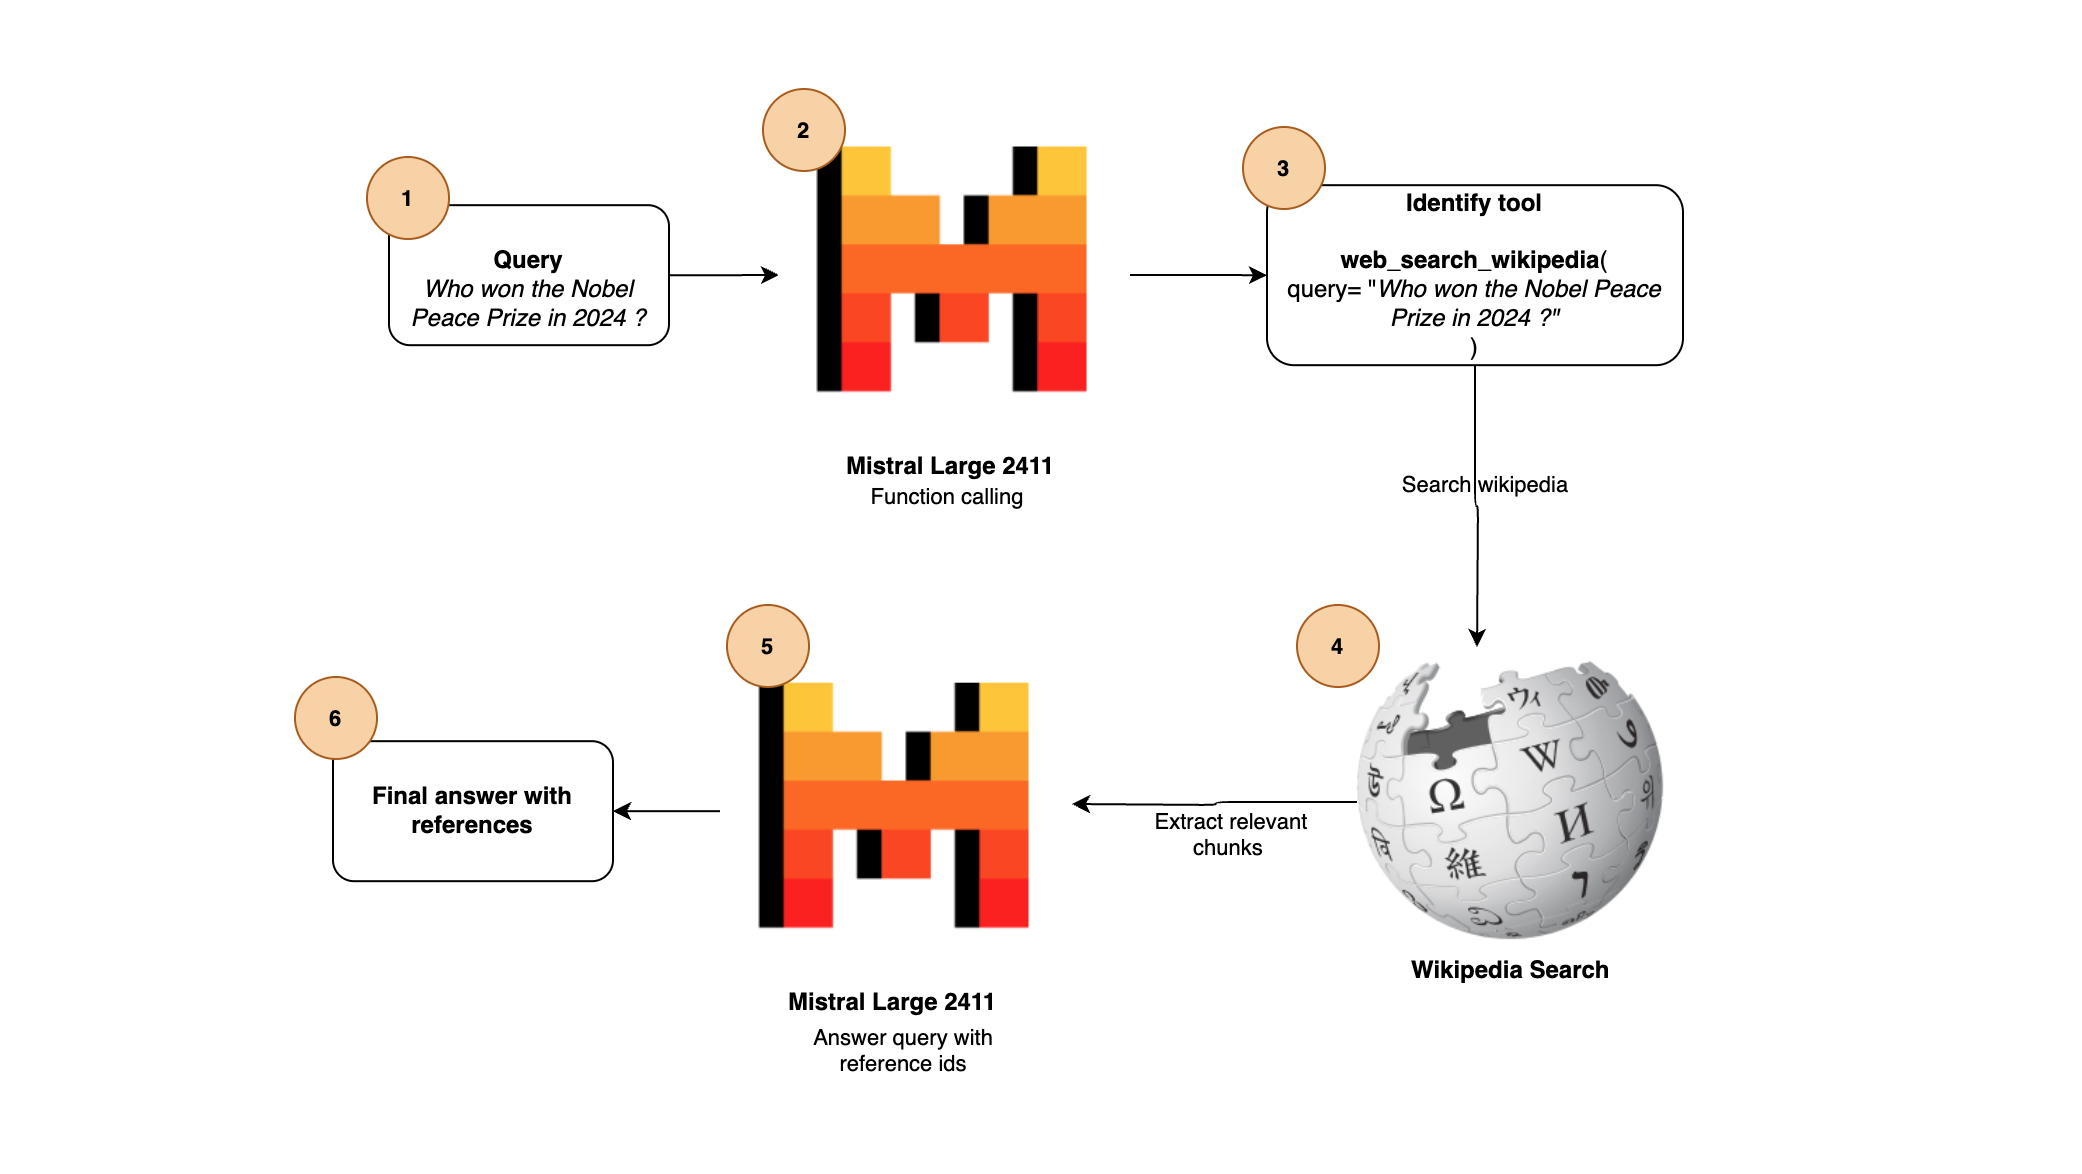

## Step-by-Step Process Overview

Here’s a detailed breakdown of the workflow depicted in the image:

### 1. Query Initiation:

The process begins with a user submitting a query to the system.

### 2. Function Call Triggered by Mistral Large:

The query is processed by the Mistral Large model, which determines that additional information is needed. To address this, the model initiates a function call and identifies the most suitable tool for the query.

### 3. Tool Selection:

The Mistral Large model selects the appropriate tool for the task. In this example, it identifies web_search_wikipedia as the tool to use and passes the user’s query as an argument.

### 4. Wikipedia Search Execution:

The web_search_wikipedia tool performs a search on Wikipedia using the provided query.

### 5. Extracting Relevant Information:

The search results are analyzed to extract the most relevant chunks of information. These extracted chunks are then structured and prepared for use as references in the final output.

### 6. Generating the Final Answer with References:

The processed chat history, along with the extracted information, is returned to the Mistral Large model. The model uses this data to generate a comprehensive response that incorporates references to the relevant Wikipedia articles, ensuring the answer is accurate, well-supported, and transparent.

This step-by-step approach ensures that the responses are not only precise but also verifiable through clearly cited sources.

In [ ]:
!pip install mistralai==1.2.3 wikipedia==1.4.0

## Step 1: Initialize the Mistral client

In this step, we initialize the Mistral client using your API key, which can be obtained or generated from the Mistral API dashboard. Note: It may take up to one minute for your API key to become fully activated after creation.

In [ ]:
from mistralai import Mistral
from mistralai.models import  UserMessage, SystemMessage
import os

client = Mistral(
    api_key=os.environ["MISTRAL_API_KEY"],
)


query = "Who won the Nobel Peace Prize in 2024?"

#Add the user message to the chat_history
chat_history = [
    SystemMessage(content="You are a helpful assistant that can search the web for information. Use context to answer the question."),
    UserMessage(content=query),
]
print(chat_history)

## Step 2 : Define the function calling tool to search Wikipedia.

Function calling enables Mistral models to seamlessly interact with external tools, such as user-defined functions or APIs. This integration empowers users to develop applications tailored to specific use cases and real-world challenges.

To demonstrate, we first create a tool that queries the Wikipedia API and returns the results in a structured format. Once the tool is set up, it can be utilized in a chat completion request to the Mistral model. The response will include the following details:

- The name of the tool.
- A unique tool call ID.
- Arguments containing the user’s query.

In [ ]:
web_search_tool = {
    "type": "function",
    "function": {
        "name": "web_search",
        "description": "Search the web for a query for which you do not know the answer",
        "parameters": {
            "type": "object",
            "properties": {
                "query": {
                    "type": "string",
                    "description": "Query to search the web in keyword form.",
                }
            },
            "required": ["query"],
        },
    },
}



chat_response = client.chat.complete(
    model="mistral-large-latest",
    messages=chat_history,
    tools=[web_search_tool],
)


if hasattr(chat_response.choices[0].message, 'tool_calls'):
    tool_call = chat_response.choices[0].message.tool_calls[0]
    chat_history.append(chat_response.choices[0].message)
    print(tool_call)
else:
    print("No tool call found in the response")

## Step 3: Define Method to Search Wikipedia Associated with the Tool

In the previous step, we created a tool named web_search_wikipedia. Next, we need to define a function that processes the tool call ID and its arguments, returning the results in the required format.

The output should adhere to the following structure:

```python
{
    "url": str | None,        # Page URL
    "title": str | None,      # Page title 
    "description": str | None, # Page description
    "snippets": List[str],    # Relevant text snippets in a list
    "date": str | None,       # date
    "source": str | None,      # Source/reference
    "metadata": Dict[str, Any] # Metadata
}
```

In [ ]:
import wikipedia
import json
from datetime import datetime


def get_wikipedia_search(query: str) -> str:
    """
    Search Wikipedia for a query and return the results in a specific format.
    """
    result = wikipedia.search(query, results = 5)
    data={}
    for i, res in enumerate(result):
        pg= wikipedia.page(res, auto_suggest=False)
        data[i]={
            "url": pg.url,
            "title": pg.title,
            "snippets": [pg.summary.split('.')],
            "description": None,
            "date": datetime.now().isoformat(),
            "source": "wikipedia"
        }
    return json.dumps(data, indent=2)

## Step 4: Perform the Tool Call and Search Wikipedia
Now that we have the tool call ID and the arguments, we can perform the tool call and search Wikipedia.

In [ ]:
import json
from mistralai import ToolMessage


query = json.loads(tool_call.function.arguments)["query"]
wb_result = get_wikipedia_search(query)

tool_call_result = ToolMessage(
    content=wb_result,
    tool_call_id=tool_call.id,
    name=tool_call.function.name,
)


# Append the tool call message to the chat_history
chat_history.append(tool_call_result)

#See chunks in the response
print(json.dumps(json.loads(wb_result), indent=2))

```
{
  "0": {
    "url": "https://en.wikipedia.org/wiki/2024_Nobel_Peace_Prize",
    "title": "2024 Nobel Peace Prize",
    "snippets": [
      [
        "The 2024 Nobel Peace Prize, an international peace prize established according to Alfred Nobel's will, was awarded to Nihon Hidankyo (the Japan Confederation of A- and H-Bomb Sufferers Organizations), for their activism against nuclear weapons, assisted by victim/survivors (known as Hibakusha) of the atomic bombings of Hiroshima and Nagasaki in 1945",
        " They will receive the prize at a ceremony on 10 December 2024 at Oslo, Norway",
        ""
      ]
    ],
    "description": null,
    "date": "2024-11-26T17:39:55.057454",
    "source": "wikipedia"
  }
}
```

## Step 5: Call Mistral with the Tool Call Result
The chat history now contains:

- The `System` message which contains the instructions for the assistant
- The `User` message which contains the original question
- The `Assistant` message which contains a tool call to search Wikipedia
- The `Tool call` result which contains the results of the Wikipedia search

See more information about types of messages [here](https://docs.mistral.ai/capabilities/completion/#chat-messages).

In [ ]:
for msg in chat_history:
    print(msg,end='\n')

```
content='You are a helpful assistant that can search the web for information. Use context to answer the question.' role='system'
content='Who won the Nobel Peace Prize in 2024?' role='user'
content='' tool_calls=[ToolCall(function=FunctionCall(name='web_search', arguments='{"query": "Who won the Nobel Peace Prize in 2024?"}'), id='3xdgHbIKY', type='function')] prefix=False role='assistant'
content='{\n  "0": {\n    "url": "https://en.wikipedia.org/wiki/2024_Nobel_Peace_Prize",\n    "title": "2024 Nobel Peace Prize",\n    "snippets": [\n      [\n        "The 2024 Nobel Peace Prize, an international peace prize established according to Alfred Nobel\'s will, was awarded to Nihon Hidankyo (the Japan Confederation of A- and H-Bomb Sufferers Organizations), for their activism against nuclear weapons, assisted by victim/survivors (known as Hibakusha) of the atomic bombings of Hiroshima and Nagasaki in 1945",\n        " They will receive the prize at a ceremony on 10 December 2024 at Oslo, Norway",\n        ""\n      ]\n    ],\n    "description": null,\n    "date": "2024-11-26T17:39:55.057454",\n    "source": "wikipedia"\n  }', tool_call_id='3xdgHbIKY' name='web_search' role='tool'}'
```

In [ ]:
from mistralai.models import TextChunk, ReferenceChunk

def format_response(chat_response: list, wb_result:dict):
    print("\n🤖 Answer:\n")
    refs_used = []
    
    # Print the main response
    for chunk in chat_response.choices[0].message.content:
        if isinstance(chunk, TextChunk):
            print(chunk.text, end="")
        elif isinstance(chunk, ReferenceChunk):
            refs_used += chunk.reference_ids
        
    
    # Print references
    if refs_used:
        print("\n\n📚 Sources:")
        for i, ref in enumerate(set(refs_used), 1):
            reference = json.loads(wb_result)[str(ref)]
            print(f"\n{i}. {reference['title']}: {reference['url']}")
            

# Use the formatter
chat_response = client.chat.complete(
    model="mistral-large-latest",
    messages=chat_history,
    tools=[web_search_tool],
)
format_response(chat_response, wb_result)

🤖 Answer:

The 2024 Nobel Peace Prize was awarded to Nihon Hidankyo, the Japan Confederation of A- and H-Bomb Sufferers Organizations, for their activism against nuclear weapons, supported by survivors of the 1945 atomic bombings of Hiroshima and Nagasaki. The award ceremony will take place on December 10, 2024, in Oslo, Norway.

📚 Sources:

1. 2024 Nobel Peace Prize : https://en.wikipedia.org/wiki/2024_Nobel_Peace_Prize

2. Nobel Peace Prize: https://en.wikipedia.org/wiki/Nobel_Peace_Prize

## Step 6 : Streaming completion with references

In [ ]:
stream_response = client.chat.stream(
    model="mistral-large-2411",
    messages=chat_history,
    tools=[web_search_tool],
)

last_reference_index = 0
if stream_response is not None:
    for event in stream_response:
        chunk = event.data.choices[0]
        if chunk.delta.content:
            if isinstance(chunk.delta.content, list):
                    # Check if TYPE of chunk is a reference
                    references_ids = [
                        ref_id
                        for chunk_elem in chunk.delta.content
                        if chunk_elem.TYPE == "reference"
                        for ref_id in chunk_elem.reference_ids
                    ]
                    last_reference_index += len(references_ids)

                    # Map the references ids to the references data stored in the chat history
                    references_data = [json.loads(wb_result)[str(ref_id)] for ref_id in references_ids]
                    urls = " " + ", ".join(
                        [
                            f"[{i}]({reference['url']})"
                            for i, reference in enumerate(
                                references_data,
                                start=last_reference_index - len(references_ids) + 1,
                            )
                        ]
                    )
                    print(urls, end="")
            else:
                print(chunk.delta.content, end="")


The 2024 Nobel Peace Prize was awarded to Nihon Hidankyo (the Japan Confederation of A- and H-Bomb Sufferers Organizations) for their activism against nuclear weapons, 
assisted by victim/survivors (known as Hibakusha) of the atomic bombings of Hiroshima and Nagasaki in 1945 [1](https://en.wikipedia.org/wiki/2024_Nobel_Peace_Prize), [2](https://en.wikipedia.org/wiki/Nobel_Peace_Prize).